In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)

import matplotlib.pyplot as plt
%matplotlib inline

# Import files & Merge

We used four datasets 
- Steps extracted from iphone Health app (Preparing_Data.ipynb) (33k records)
- Sleep processed from steps (Preparing_Data.ipynb) (1200 daily record)
- Calendar scrapped from two websites (Web_Scrapping_Calendar.ipynb & Web_Scrapping_Schools.ipynb) (14600 records)
- Weather scrapped from website 

In [12]:
Steps0 = pd.read_csv("Steps.csv")
Calendar = pd.read_csv("Calendar.csv")
Sleep = pd.read_csv("Sleep_Schedule.csv")
Weather = pd.read_csv("weather.csv")

#Weather['date'] = pd.to_datetime(Weather['date'])

Sleep.columns = Sleep.columns.str.strip()
Calendar.columns = Calendar.columns.str.strip()


#Calendar columns we want 
Weather = Weather[['date','temp_min','temp_max','is_rain']]
Calendar = Calendar[['Date','AD_Month','AH_Month',"Long_Vacation","Short_Vacation","Ramadan","Sch_Eid_Fatr","National_Day","National_Day_Ext","AD_WeekdayNum"]]
Steps0 = Steps0[["Date","Steps"]]
Sleep = Sleep[['Date','Woke_Hour']]



Merged = pd.merge(Steps0,Calendar,how="left",on="Date")
Merged = pd.merge(Merged,Sleep,how='left',on="Date")
Merged = pd.merge(Merged,Weather,how='left',left_on='Date',right_on='date')
Merged.sort_values('Date',inplace=True)
#delete unneeded columns
del Merged['date']

Merged['is_rain'] = Merged['is_rain'].astype('int')
Merged = Merged.sort_values("Date")
#save Merged file for EDA
Merged.to_csv("Merged.csv")
# remove date column

Merged = Merged.iloc[:,1:]




In [3]:
Merged

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,Woke_Hour,temp_min,temp_max,is_rain
0,3140,6,9,1,0,1,0,0,0,5,18,86,111,0
1,9810,6,9,1,0,1,0,0,0,6,20,88,113,0
2,6551,6,9,1,0,1,0,0,0,0,6,90,111,0
3,6107,6,9,1,0,1,0,0,0,1,6,88,113,0
4,2569,6,9,1,0,1,0,0,0,2,6,86,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4454,9,2,0,0,0,0,0,0,3,3,73,100,0
1203,3702,9,2,0,0,0,0,0,0,4,6,73,100,0
1204,3939,9,2,0,0,0,0,0,0,5,8,77,104,0
1205,2847,9,2,0,0,0,0,0,1,6,4,77,102,0


# Correlation Analysis

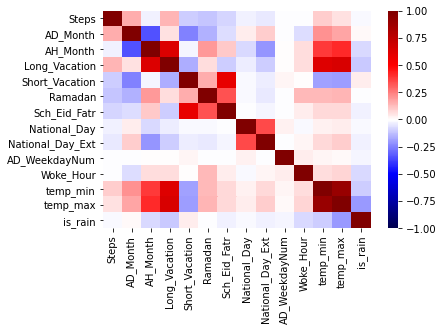

In [4]:
## correlation matrix,  and pair plot
Merged.corr()["Steps"]
sns.heatmap(Merged.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

# Generate Lag values

In [10]:
# Generate lag1 to lag 8  for time-series regression
for i in range(1,9):
    Merged['Lag'+str(i)] = Merged['Steps'].shift(i)


Merged = Merged.dropna()
Merged

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,...,temp_max,is_rain,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8
24,4074,6,10,1,0,0,0,0,0,1,...,108,0,3855.0,4106.0,11375.0,9123.0,8302.0,11490.0,14337.0,15417.0
25,4845,6,10,1,0,0,0,0,0,2,...,108,0,4074.0,3855.0,4106.0,11375.0,9123.0,8302.0,11490.0,14337.0
26,972,6,10,1,0,0,0,0,0,3,...,111,0,4845.0,4074.0,3855.0,4106.0,11375.0,9123.0,8302.0,11490.0
27,884,6,10,1,0,0,0,0,0,4,...,111,0,972.0,4845.0,4074.0,3855.0,4106.0,11375.0,9123.0,8302.0
28,1494,6,10,1,0,0,0,0,0,5,...,108,0,884.0,972.0,4845.0,4074.0,3855.0,4106.0,11375.0,9123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4454,9,2,0,0,0,0,0,0,3,...,100,0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0,2378.0
1203,3702,9,2,0,0,0,0,0,0,4,...,100,0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0
1204,3939,9,2,0,0,0,0,0,0,5,...,104,0,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0
1205,2847,9,2,0,0,0,0,0,1,6,...,102,0,3939.0,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0


# Normalization

In [25]:
Norm_Merged=(Merged-Merged.mean())/Merged.std()
Norm_Merged

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,...,temp_max,is_rain,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8
8,0.077199,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,1.497814,...,1.077436,-0.185698,-0.552813,-0.862393,-0.390251,-0.302354,0.780624,0.916101,1.909126,-0.129858
9,-0.415612,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-1.497814,...,0.952312,-0.185698,0.076810,-0.552115,-0.861920,-0.389947,-0.302709,0.780178,0.912927,1.909052
10,2.442935,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-0.998542,...,0.952312,-0.185698,-0.416165,0.077325,-0.551660,-0.861598,-0.390282,-0.302927,0.777207,0.912829
11,2.048748,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-0.499271,...,0.764625,-0.185698,2.443333,-0.415506,0.077743,-0.551350,-0.861828,-0.390481,-0.304276,0.777105
12,1.979528,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,0.000000,...,0.639501,-0.185698,2.049015,2.443160,-0.415059,0.078030,-0.551649,-0.861929,-0.391699,-0.304404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,0.274140,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.000000,...,0.389252,-0.185698,0.578363,-0.251025,-0.272333,0.281085,0.238651,-0.789375,-0.383446,-0.362789
1203,0.043814,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.499271,...,0.389252,-0.185698,0.273816,0.578733,-0.250587,-0.272034,0.280600,0.238319,-0.789995,-0.383576
1204,0.116403,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.998542,...,0.639501,-0.185698,0.043414,0.274274,0.579122,-0.250289,-0.272395,0.280260,0.236160,-0.790135
1205,-0.218058,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,7.147572,1.497814,...,0.514377,-0.185698,0.116027,0.043939,0.274681,0.579390,-0.250655,-0.272619,0.278037,0.236045


# Modelling

0.31350894202938295


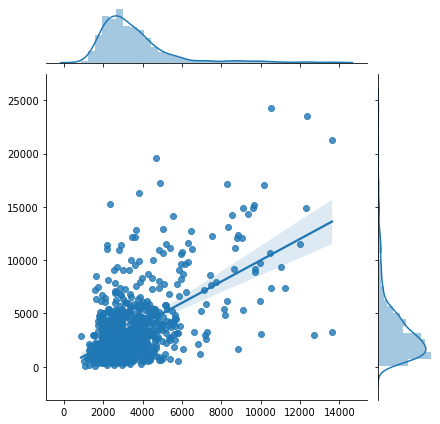

In [11]:


#features = ["AD_Month","AH_Month","Long_Vacation","Short_Vacation","Ramadan","Sch_Eid_Adha","Sch_Eid_Fatr","National_Day","National_Day_ext","AD_Weekdaynum","Woke_Hour"]


y = Merged.iloc[:,:1]
x_org = Merged.iloc[:,1:]
x_org
x = x_org.copy()
#x = x.loc[:,["Lag1","Lag2","Lag3","Lag4","Lag5","Lag6","Lag7","AD_WeekdayNum","Long_Vacation","Short_Vacation","Ramadan","National_Day_Ext","Woke_Hour"]].copy()
x = x.loc[:,["Lag1","Lag2","Lag3","Lag4","Lag5","Lag6","Lag7","Long_Vacation","AD_Month","temp_min"]].copy()

#del x['Sch_Eid_Adha']
#del x['Sch_Eid_Fatr']
#del x['National_Day']
#del x['National_Day_Ext']
#del x['Woke_Hour']
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_test,y_test))
#y, X = patsy.dmatrices('Steps ~  AD_WeekdayNum', data=Merged, return_type="dataframe")
mean_absolute_error(lm.predict(X_test),y_test)
# Create your model
#model = sm.OLS(y, X)
#lm.predict(X_test)
# Fit your model to your training set
#fit = model.fit()

# Print summary statistics of the model's performance
#fit.summary()
preds = lm.predict(X_train) # generate predictions (on training data) using fit model

sns.jointplot(x=preds,y=y_train, kind='reg')


import pickle
filename = 'finalized_model.sav'
pickle.dump(lm, open(filename, 'wb'))

#  

## -- Cross- Validation

In [12]:

# selected_columns =  Merged.loc[:,["Lag1","Lag2","Lag3","Lag4","Lag5","Lag6","Lag7","Long_Vacation","AD_Month","temp_min"]].copy()


# y = selected_columns.iloc[:,:1]
# x_org = selected_columns.iloc[:,1:]
# selected_columns
kf = KFold(n_splits=5, shuffle=True, random_state=0)



,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Long_Vacation,AD_Month,temp_min
8,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,9810.0,1,6,93
9,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,1,6,82
10,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,1,6,81
11,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,1,6,84
12,10248.0,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,1,6,81
...,...,...,...,...,...,...,...,...,...,...
1202,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0,0,9,73
1203,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,0,9,73
1204,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,0,9,77
1205,3939.0,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,0,9,77


## -- Regularization

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

params = {"alpha": np.linspace(0, 1, num=100)}
GS = GridSearchCV(Lasso(), param_grid=params, cv=kf, return_train_score=False)
GS.fit(X_train, y_train)
GS.best_estimator_.alpha

cross_val_score(Lasso(alpha= GS.best_estimator_.alpha), X_train, y_train, cv=kf)

C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2359107061.909729, tolerance: 773523.2204697466
  model = cd_fast.enet_coordinate_descent(
C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


array([0.05406769, 0.23086804, 0.36930981, 0.44495194, 0.28134055])

0.3574665525490285


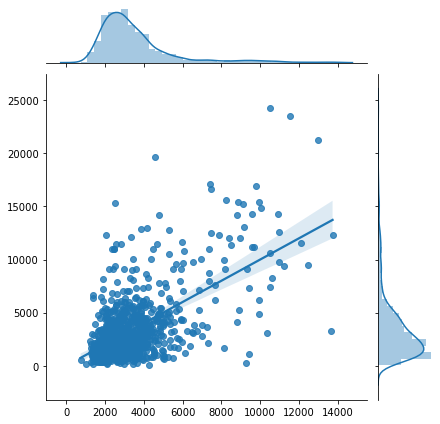

In [44]:
# loop through each feature and log r squared
rsq = []
mse = []
features = ["is_rain","temp_min","temp_max","AD_Month","AH_Month","Long_Vacation","Short_Vacation","Ramadan","Sch_Eid_Adha","Sch_Eid_Fatr","National_Day","National_Day_Ext","AD_WeekdayNum","Woke_Hour"]
for feature in features:
    x = x_org.copy()
    x = x.loc[:,[feature]].copy()
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    rsq.append(lm.score(X_test,y_test))
    mse.append(mean_absolute_error(lm.predict(X_test),y_test))
    #y, X = patsy.dmatrices('Steps ~  AD_WeekdayNum', data=Merged, return_type="dataframe")
    
list(zip(features,rsq))

[('is_rain', -0.0052751593886384285),
 ('temp_min', 0.008070591527205129),
 ('temp_max', 0.0018472179881753314),
 ('AD_Month', 0.006529392232651476),
 ('AH_Month', -0.0239820285048693),
 ('Long_Vacation', 0.028176756272644377),
 ('Short_Vacation', 0.003504125152054116),
 ('Ramadan', 0.008162157896928313),
 ('Sch_Eid_Adha', -0.004284802024396406),
 ('Sch_Eid_Fatr', 0.00370217457120936),
 ('National_Day', -0.0040274452651380965),
 ('National_Day_Ext', -0.001418733192048327),
 ('AD_WeekdayNum', -0.006381166636464819),
 ('Woke_Hour', -0.012088361021947103)]

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Regression:", r2_score(y_test, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
print("Gradient Boosted Regression:", r2_score(y_test, y_pred))

In [ ]:
Steps = Steps.dropna()
y = Steps.iloc[:,1:2]
x = Steps.iloc[:,2:]
#split 800, the rest 407
X_train = x[:800]
X_test = x[800:]
y_train = y[:800]
y_test = y[800:]

X_test

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)
#print(X_test)
score = lm.score(X_test,y_test)
#y, X = patsy.dmatrices('Steps ~  AD_WeekdayNum', data=Merged, return_type="dataframe")
print(mean_absolute_error(lm.predict(X_test),y_test))
print(score)

In [ ]:
lm.predict(pd.DataFrame(columns=['Lag1'],data=[7]))

# Neural Network

In [8]:


import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [26]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(36, input_dim=21, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
y = Norm_Merged.iloc[:,:1]
x_org = Norm_Merged.iloc[:,1:]
x_org
x = x_org.copy()
X_train, X_test, y_train, y_test = train_test_split(x_org,y, test_size=0.3, random_state=42)
X_train

,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,Woke_Hour,...,temp_max,is_rain,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8
530,1.322504,-1.010386,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.000000,-0.917099,...,-0.799428,-0.185698,1.053567,0.556373,1.440684,-0.091030,2.872882,-0.048223,-0.113840,-0.037236
221,-1.686381,-0.456832,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,-0.499271,-0.917099,...,-1.174801,-0.185698,0.213764,0.138584,-0.601889,-0.496834,-0.850499,-0.801008,0.512185,0.307881
128,1.021616,-1.563939,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,-1.497814,-0.917099,...,0.201566,-0.185698,0.230309,1.692121,-0.766361,-1.082111,0.213543,-0.310886,2.178121,0.259888
924,1.623393,-0.733609,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.998542,0.424083,...,-1.362488,-0.185698,0.540984,0.191574,0.327667,0.584903,0.263760,0.753544,-0.640520,-0.735418
1074,-0.482827,0.650276,-0.669099,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-0.998542,-1.084747,...,0.514377,-0.185698,-0.422905,-0.714758,-0.437418,-0.728066,-0.863053,-0.750802,-0.181088,-0.365235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,-0.783715,0.650276,-0.669099,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-1.497814,0.759379,...,0.201566,-0.185698,-0.981140,-0.578762,-0.867739,-0.721941,-0.043358,-0.981015,-0.432966,-0.560566
1103,-0.181938,0.927052,1.493300,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,-0.499271,-0.078860,...,1.077436,-0.185698,-0.847556,0.252833,-0.370649,0.820422,-0.510618,-0.904787,-0.383752,-0.917605
1138,0.118950,1.480606,1.493300,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,-0.499271,-0.414156,...,1.077436,-0.185698,-0.052485,-0.807566,-0.174324,-0.871093,0.777868,-0.985301,-0.757594,-0.823149
868,1.021616,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.998542,-1.252394,...,-0.173807,-0.185698,-0.581000,-0.196504,-0.627923,-0.136970,-0.490103,0.473737,0.765897,0.516051


In [23]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
#kfold = KFold(n_splits=4)
#results = cross_val_score(pipeline, x_org, y, cv=kfold)
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, batch_size=5, verbose=1)
estimator.fit(X_train,y_train)
estimator.score(X_test,y_test)

Epoch 1/1000
168/168 [==============================] - 1s 1ms/step - loss: 11968237.0000
Epoch 2/1000
168/168 [==============================] - 0s 2ms/step - loss: 7680515.5000
Epoch 3/1000
168/168 [==============================] - 0s 1ms/step - loss: 7275579.0000
Epoch 4/1000
168/168 [==============================] - 0s 1ms/step - loss: 7204736.0000
Epoch 5/1000
168/168 [==============================] - 0s 1ms/step - loss: 7165311.0000
Epoch 6/1000
168/168 [==============================] - 0s 1ms/step - loss: 7185346.5000
Epoch 7/1000
168/168 [==============================] - 0s 1ms/step - loss: 7047812.5000
Epoch 8/1000
168/168 [==============================] - 0s 2ms/step - loss: 7202603.0000
Epoch 9/1000
168/168 [==============================] - 0s 2ms/step - loss: 7165091.5000
Epoch 10/1000
168/168 [==============================] - 0s 1ms/step - loss: 7020308.0000
Epoch 11/1000
168/168 [==============================] - 0s 2ms/step - loss: 7154620.5000
Epoch 12/1000
168/

KeyboardInterrupt: 

In [11]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, x_org, y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))
estimator.fit()

Baseline: -7283363.50 (2941509.49) MSE


In [ ]:
plt.plot(results)

In [27]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, batch_size=5, verbose=1)
estimator.fit(X_train,y_train,validation_data=(X_test,y_test))

Epoch 1/1000
168/168 [==============================] - 1s 3ms/step - loss: 0.8603 - val_loss: 0.7404
Epoch 2/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.6621 - val_loss: 0.6891
Epoch 3/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.6287 - val_loss: 0.6593
Epoch 4/1000
168/168 [==============================] - 1s 3ms/step - loss: 0.6074 - val_loss: 0.6508
Epoch 5/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.5871 - val_loss: 0.6610
Epoch 6/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.5789 - val_loss: 0.6460
Epoch 7/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.5722 - val_loss: 0.6647
Epoch 8/1000
168/168 [==============================] - ETA: 0s - loss: 0.569 - 1s 4ms/step - loss: 0.5549 - val_loss: 0.6650
Epoch 9/1000
168/168 [==============================] - 0s 2ms/step - loss: 0.5494 - val_loss: 0.6396
Epoch 10/1000
168/168 [==============================] - 0

168/168 [==============================] - 1s 4ms/step - loss: 0.1119 - val_loss: 1.2684
Epoch 160/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.1119 - val_loss: 1.1908
Epoch 161/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.1138 - val_loss: 1.2896
Epoch 162/1000
168/168 [==============================] - 1s 3ms/step - loss: 0.1065 - val_loss: 1.2918
Epoch 163/1000
168/168 [==============================] - 0s 2ms/step - loss: 0.1041 - val_loss: 1.2904
Epoch 164/1000
168/168 [==============================] - 0s 2ms/step - loss: 0.1044 - val_loss: 1.2823
Epoch 165/1000
168/168 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 1.2628
Epoch 166/1000
168/168 [==============================] - 0s 2ms/step - loss: 0.1067 - val_loss: 1.2784
Epoch 167/1000
168/168 [==============================] - 0s 2ms/step - loss: 0.1067 - val_loss: 1.2140
Epoch 168/1000
168/168 [==============================] - 0s 2ms/step - loss: 0

KeyboardInterrupt: 

In [44]:
#(y*y.std())+y.mean()*y.std()
#Norm_Merged=(Merged-Merged.mean())/Merged.std()
#Norm_Merged
y
#(Merged['Steps'].mean()+ y) * Merged['Steps'].std()

,Steps
8,0.077199
9,-0.415612
10,2.442935
11,2.048748
12,1.979528
...,...
1202,0.274140
1203,0.043814
1204,0.116403
1205,-0.218058
